## 1. Conversion to .wav
##### Convert to wav and splits them into train, val, and test sets. It uses multithreading for fast conversion and generates CSVs for each split. Missing files and errors are logged, and filenames are kept unique to avoid overwrites.

In [7]:
import os
import csv
import concurrent.futures
import random
from pathlib import Path
from pydub import AudioSegment # Make sure ffmpeg/ffprobe is installed and accessible
from tqdm import tqdm
import math
import re # Import regex for sorting

# --- Configuration ---
EMBEDDINGS_DIR = Path("/home/teaching/embeddings")
AUDIO_SOURCE_DIR = Path("/home/teaching/Desktop/Dataset_official/archive/Language_Detection_Dataset")
TARGET_BASE_DIR = Path("/home/teaching/split_data_unique_names") # Suggest changing target dir name

# Split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

assert math.isclose(TRAIN_RATIO + VAL_RATIO + TEST_RATIO, 1.0), "Split ratios must sum to 1.0"

TRAIN_FOLDER = "train"
VAL_FOLDER = "val"
TEST_FOLDER = "test"

TRAIN_CSV = "train.csv"
VAL_CSV = "val.csv"
TEST_CSV = "test.csv"

try:
    LANGUAGES = sorted([d.name for d in EMBEDDINGS_DIR.iterdir() if d.is_dir()])
    print(f"Found potential language folders in {EMBEDDINGS_DIR}: {LANGUAGES}")
except FileNotFoundError:
    print(f"CRITICAL ERROR: Embeddings directory not found at {EMBEDDINGS_DIR}")
    exit(1)

FILENAME_COLUMN = 'filename'
LABEL_COLUMN = 'scene_label'
MAX_WORKERS = os.cpu_count()
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# --- Helper Function for Audio Conversion ---
# No changes needed inside this function IF the calling code provides the correct unique wav_path
def convert_mp3_to_wav(mp3_path: Path, wav_path: Path, language: str, split_name: str) -> tuple | None:
    """
    Converts an MP3 file to WAV format and saves to the correct split folder using the provided wav_path.

    Args:
        mp3_path: Path to the source MP3 file.
        wav_path: Path to save the destination WAV file (MUST include the unique filename).
        language: The language label for this file.
        split_name: The name of the split ('train', 'val', 'test').

    Returns:
        A tuple (unique_wav_filename, language, split_name) on success, None on failure.
    """
    try:
        wav_path.parent.mkdir(parents=True, exist_ok=True)
        if wav_path.exists():
            # Return the filename part of the path provided
            return (wav_path.name, language, split_name)

        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")
        # Return the filename part of the path provided
        return (wav_path.name, language, split_name)
    except FileNotFoundError:
        print(f"Warning: MP3 file disappeared before conversion: {mp3_path}")
        return None
    except Exception as e:
        print(f"ERROR converting {mp3_path.name} for language {language} to WAV ({wav_path.name}): {e}. Skipping this file.")
        if wav_path.exists():
            try:
                os.remove(wav_path)
            except OSError:
                pass
        return None

# --- Main Processing Logic ---
def main():
    print(f"Embeddings Source: {EMBEDDINGS_DIR}")
    print(f"Audio Source:      {AUDIO_SOURCE_DIR}")
    print(f"Target Base Dir:   {TARGET_BASE_DIR} (Using unique filenames like '123_English.wav')") # Notify user
    # ... (rest of initial prints)

    TARGET_BASE_DIR.mkdir(parents=True, exist_ok=True)
    (TARGET_BASE_DIR / TRAIN_FOLDER).mkdir(exist_ok=True)
    (TARGET_BASE_DIR / VAL_FOLDER).mkdir(exist_ok=True)
    (TARGET_BASE_DIR / TEST_FOLDER).mkdir(exist_ok=True)

    # ... (file scanning logic remains the same until task creation)
    files_by_language = {lang: [] for lang in LANGUAGES}
    total_embeddings_scanned = 0
    missing_audio_count = 0
    found_files_count = 0
    skipped_languages = []

    print("\nStep 1: Scanning for matching Embedding (.npy) and Audio (.mp3) files...")
    # 1. Find all matching MP3 files corresponding to existing NPY files
    for lang in LANGUAGES:
        lang_embedding_dir = EMBEDDINGS_DIR / lang
        lang_audio_dir = AUDIO_SOURCE_DIR / lang
        lang_embeddings_found_count = 0

        if not lang_embedding_dir.is_dir():
            print(f"  WARNING: Embedding directory not found for language '{lang}' ({lang_embedding_dir}), skipping this language.")
            skipped_languages.append(lang)
            continue
        if not lang_audio_dir.is_dir():
             print(f"  WARNING: Audio source directory not found for language '{lang}' ({lang_audio_dir}), skipping this language.")
             skipped_languages.append(lang)
             continue

        for npy_file in lang_embedding_dir.glob('*.npy'):
            total_embeddings_scanned += 1
            lang_embeddings_found_count += 1
            base_filename = npy_file.stem # e.g., '123'
            expected_mp3_path = lang_audio_dir / f"{base_filename}.mp3" # e.g., /path/to/English/123.mp3

            if expected_mp3_path.exists():
                # Store tuple (source_mp3_path, base_filename_without_suffix)
                files_by_language[lang].append((expected_mp3_path, base_filename))
                found_files_count +=1
            else:
                missing_audio_count += 1

    # ... (Scan Summary print remains the same)
    print("\n--- Scan Summary ---")
    print(f"Total .npy embedding files scanned across existing language folders: {total_embeddings_scanned}")
    print(f"Found {found_files_count} files where BOTH the .npy embedding AND the corresponding .mp3 audio file exist.")
    if missing_audio_count > 0:
        print(f"IMPORTANT: {missing_audio_count} audio files (.mp3) were MISSING for existing embedding files (.npy).")
        print(f"           These {missing_audio_count} files CANNOT be included in the dataset splits.")
    if skipped_languages:
        print(f"Skipped languages due to missing directories: {', '.join(skipped_languages)}")

    if found_files_count == 0:
        print("\nCRITICAL: No matching files found to process based on existing .npy and .mp3 pairs. Exiting.")
        return

    # 2. Perform stratified split
    print(f"\nStep 2: Performing stratified split on the {found_files_count} FOUND files...")
    tasks_to_process = []
    split_counts = {TRAIN_FOLDER: 0, VAL_FOLDER: 0, TEST_FOLDER: 0}
    split_details_by_lang = {}

    for lang, files in files_by_language.items():
        # ... (language skipping logic)
        if lang in skipped_languages: continue
        if not files: continue

        # ... (shuffling and split calculation logic remains the same)
        random.shuffle(files)
        num_files = len(files)
        n_train = round(num_files * TRAIN_RATIO)
        n_val = round(num_files * VAL_RATIO)
        n_test = num_files - n_train - n_val
        if n_test < 0:
             n_train += n_test
             n_test = 0
        current_total = n_train + n_val + n_test
        if current_total != num_files:
             n_train += (num_files - current_total)

        lang_train_files = files[0:n_train]
        lang_val_files = files[n_train : n_train + n_val]
        lang_test_files = files[n_train + n_val :]

        split_details_by_lang[lang] = {
            'total': num_files, TRAIN_FOLDER: len(lang_train_files),
            VAL_FOLDER: len(lang_val_files), TEST_FOLDER: len(lang_test_files)
        }

        # *** CHANGE IS HERE: Create unique target path ***
        for split_name, split_files, split_folder in [
            (TRAIN_FOLDER, lang_train_files, TRAIN_FOLDER),
            (VAL_FOLDER, lang_val_files, VAL_FOLDER),
            (TEST_FOLDER, lang_test_files, TEST_FOLDER)
        ]:
            split_counts[split_name] += len(split_files)
            for mp3_path, base_filename in split_files:
                # Construct the unique filename: base_number + _ + language + .wav
                unique_wav_filename = f"{base_filename}_{lang}.wav" # e.g., "123_English.wav"

                # Construct the full target path using the unique filename
                target_wav_path = TARGET_BASE_DIR / split_folder / unique_wav_filename

                # Add task with the unique target path
                tasks_to_process.append((mp3_path, target_wav_path, lang, split_name))
                #                           ^source   ^unique target path ^lang ^split

    # ... (Split Assignment Summary print remains the same)
    print("Split assignment complete.")
    print("\n--- Split Assignment Summary (based on found files) ---")
    print(f"  Total files assigned to Train: {split_counts[TRAIN_FOLDER]}")
    print(f"  Total files assigned to Val:   {split_counts[VAL_FOLDER]}")
    print(f"  Total files assigned to Test:  {split_counts[TEST_FOLDER]}")

    # 3. Convert and copy files using threads
    # This part now uses the unique target_wav_path prepared above
    print(f"\nStep 3: Converting {len(tasks_to_process)} MP3s to unique WAV filenames (e.g., '123_English.wav')...")
    # ... (ThreadPoolExecutor logic remains the same, as convert_mp3_to_wav now handles unique names correctly)
    csv_data = {TRAIN_FOLDER: [], VAL_FOLDER: [], TEST_FOLDER: []}
    processed_files_count = 0
    conversion_errors = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_task_details = {
            executor.submit(convert_mp3_to_wav, mp3, wav, lang, split): (mp3, lang, split)
            for mp3, wav, lang, split in tasks_to_process # wav here is the unique path
        }
        for future in tqdm(concurrent.futures.as_completed(future_to_task_details), total=len(tasks_to_process), desc="Converting"):
            mp3_path, lang, split_name_task = future_to_task_details[future]
            try:
                result = future.result()
                if result:
                    # Result is (unique_wav_filename, language, split_name)
                    unique_wav_filename, language_label, split_name_result = result
                    # Store the unique filename in CSV data
                    csv_data[split_name_result].append((unique_wav_filename, language_label))
                    processed_files_count += 1
                else:
                    conversion_errors += 1
            except Exception as exc:
                print(f'\nCRITICAL ERROR processing future for {mp3_path.name} ({lang}): {exc}')
                conversion_errors += 1

    # ... (Conversion Summary print remains the same)
    print(f"\n--- Conversion Summary ---")
    print(f"Attempted to convert {len(tasks_to_process)} files.")
    print(f"Successfully converted and copied {processed_files_count} files with unique names.")
    if conversion_errors > 0:
        print(f"Encountered {conversion_errors} errors during conversion (these files were skipped). Check logs above for details.")

    # 4. Create the split CSV files
    print("\nStep 4: Writing CSV files (using unique filenames)...")
    final_counts_in_csv = {}
    for split_name, split_csv_filename, data in [
        (TRAIN_FOLDER, TRAIN_CSV, csv_data[TRAIN_FOLDER]),
        (VAL_FOLDER, VAL_CSV, csv_data[VAL_FOLDER]),
        (TEST_FOLDER, TEST_CSV, csv_data[TEST_FOLDER])
    ]:
        csv_output_path = TARGET_BASE_DIR / split_csv_filename
        final_counts_in_csv[split_name] = len(data)
        if data:
            print(f"  Writing {len(data)} records to {csv_output_path}...")
            try:
                # --- ADJUSTED SORT KEY for "123_English.wav" format ---
                def natural_sort_key(item):
                    # Use regex to split filename like "123_English.wav" into text and number parts
                    filename = Path(item[0]).stem # Get "123_English"
                    parts = re.split(r'(\d+)', filename) # Split into ['','123','_English'] or similar
                    # Convert numeric parts to integers for correct sorting
                    return [int(part) if part.isdigit() else part.lower() for part in parts]

                data.sort(key=natural_sort_key) # Use natural sort key

                with open(csv_output_path, 'w', newline='', encoding='utf-8') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([FILENAME_COLUMN, LABEL_COLUMN]) # Header
                    writer.writerows(data) # Data rows
            except IOError as e:
                print(f"  ERROR writing CSV file {csv_output_path}: {e}")
                final_counts_in_csv[split_name] = 0
        else:
            print(f"  No data processed for {split_name} split, skipping {split_csv_filename}.")

    # ... (Final Summary print remains largely the same, maybe add note about filenames)
    print("\n--- Final Summary ---")
    # ... (print counts)
    print("\n--- Explanation for Final Count ---")
    print("The final number of files in your train/val/test splits depends *only* on the files that met ALL criteria:")
    print("  1. An embedding file (.npy) existed.")
    print("  2. A corresponding audio file (.mp3) existed in the correct language folder.")
    print("  3. The MP3 file could be successfully converted to WAV.")
    print("  NOTE: Filenames in train/val/test are now unique (e.g., '123_English.wav') to prevent overwrites.") # Added Note
    print("If the total count is lower than expected (e.g., 1000 per language), the most likely reasons are:")
    print("  - Not enough initial .npy files in the embedding directories.")
    print("  - Missing .mp3 files for existing .npy files (check the 'MISSING' count in the Scan Summary).")
    print("  - Audio conversion errors (check the 'errors during conversion' count in the Conversion Summary).")
    print("  - Entire language directories missing in either embeddings or audio source paths.")

    print("\nScript finished.")
    
if __name__ == "__main__":
    main()

Found potential language folders in /home/teaching/embeddings: ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']
Embeddings Source: /home/teaching/embeddings
Audio Source:      /home/teaching/Desktop/Dataset_official/archive/Language_Detection_Dataset
Target Base Dir:   /home/teaching/split_data_unique_names (Using unique filenames like '123_English.wav')

Step 1: Scanning for matching Embedding (.npy) and Audio (.mp3) files...

--- Scan Summary ---
Total .npy embedding files scanned across existing language folders: 10000
Found 10000 files where BOTH the .npy embedding AND the corresponding .mp3 audio file exist.

Step 2: Performing stratified split on the 10000 FOUND files...
Split assignment complete.

--- Split Assignment Summary (based on found files) ---
  Total files assigned to Train: 8000
  Total files assigned to Val:   1000
  Total files assigned to Test:  1000

Step 3: Converting 10000 MP3s to unique WAV filenames (e.g

Converting: 100%|██████████| 10000/10000 [04:35<00:00, 36.25it/s]



--- Conversion Summary ---
Attempted to convert 10000 files.
Successfully converted and copied 10000 files with unique names.

Step 4: Writing CSV files (using unique filenames)...
  Writing 8000 records to /home/teaching/split_data_unique_names/train.csv...
  Writing 1000 records to /home/teaching/split_data_unique_names/val.csv...
  Writing 1000 records to /home/teaching/split_data_unique_names/test.csv...

--- Final Summary ---

--- Explanation for Final Count ---
The final number of files in your train/val/test splits depends *only* on the files that met ALL criteria:
  1. An embedding file (.npy) existed.
  2. A corresponding audio file (.mp3) existed in the correct language folder.
  3. The MP3 file could be successfully converted to WAV.
  NOTE: Filenames in train/val/test are now unique (e.g., '123_English.wav') to prevent overwrites.
If the total count is lower than expected (e.g., 1000 per language), the most likely reasons are:
  - Not enough initial .npy files in the embed

## 2. Converting numpy files to smaller files for easier processing

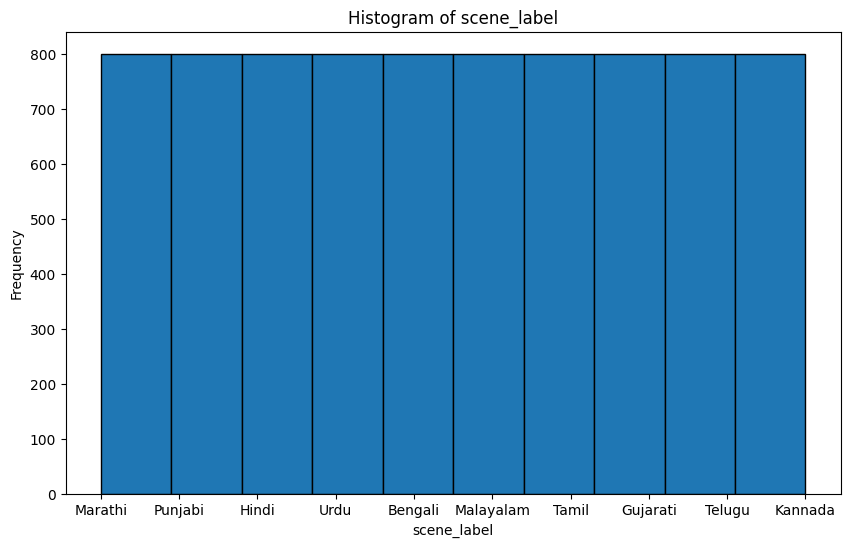

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Replace with your details ---
file_path = '/home/teaching/split_data/train.csv'  # Replace 'your_file.csv' with the actual path to your CSV file
column_name = 'scene_label'  # Replace 'your_column' with the name of the column you want to plot

# --- Code to plot the histogram ---
try:
    # 1. Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # 2. Check if the specified column exists
    if column_name in df.columns:
        # 3. Select the data from the specified column
        data_to_plot = df[column_name]

        # Remove missing values if any, as hist() can't handle them directly
        data_to_plot = data_to_plot.dropna()

        # 4. Create the histogram
        plt.figure(figsize=(10, 6)) # Adjust figure size if needed
        plt.hist(data_to_plot, bins=10, edgecolor='black') # You can adjust the number of 'bins'

        # Add labels and title for clarity
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column_name}')

        # Show the plot
        plt.show()

    else:
        print(f"Error: Column '{column_name}' not found in the CSV file.")
        print(f"Available columns are: {list(df.columns)}")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

In [2]:
import os
import pandas as pd

# --- Configuration ---
# PLEASE REPLACE THIS WITH THE ACTUAL PATH TO YOUR BASE DIRECTORY
BASE_DIR = '/home/teaching/embeddings' # <--- IMPORTANT: Change this line!

LANGUAGE_FOLDERS = [
    'Bengali', 'Urdu', 'Gujarati', 'Hindi', 'Kannada',
    'Malayalam', 'Marathi', 'Punjabi', 'Tamil', 'Telugu'
]
SEPARATOR = '_' # The character to put between the original name and the label

# --- Safety Check ---
if not os.path.isdir(BASE_DIR):
    print(f"FATAL ERROR: Base directory not found or is not a directory: {BASE_DIR}")
    print("Please correct the BASE_DIR variable in the script.")
    sys.exit(1) # Exit the script if base directory is invalid

print(f"Starting file renaming process in base directory: {BASE_DIR}")
print("Will rename files from 'filename.ext' to 'filename_FolderName.ext'")

# --- Main Processing Logic ---

# Loop through each specified language folder name
for lang_folder_name in LANGUAGE_FOLDERS:
    lang_folder_path = os.path.join(BASE_DIR, lang_folder_name)
    label_to_add = f"{SEPARATOR}{lang_folder_name}" # e.g., "_Bengali"

    print(f"\nChecking folder: {lang_folder_path}")

    # Check if the language-specific directory exists
    if not os.path.isdir(lang_folder_path):
        print(f"  WARNING: Folder not found, skipping.")
        continue

    # List all entries (files and subdirectories) in the language folder
    try:
        entries = os.listdir(lang_folder_path)
    except OSError as e:
        print(f"  ERROR: Could not list files in {lang_folder_path}: {e}")
        continue

    print(f"  Found {len(entries)} entries. Renaming files...")

    # Loop through each entry in the directory
    renamed_count = 0
    skipped_count = 0
    error_count = 0
    for filename in entries:
        current_file_path = os.path.join(lang_folder_path, filename)

        # Process only if it's a file
        if os.path.isfile(current_file_path):
            try:
                # Split the filename into name and extension
                base_name, extension = os.path.splitext(filename)

                # Check if the label is already in the filename base
                # This prevents renaming files multiple times if script is rerun
                if label_to_add in base_name:
                    # print(f"    Skipping (already renamed?): {filename}")
                    skipped_count += 1
                    continue

                # Construct the new filename
                new_filename = f"{base_name}{label_to_add}{extension}"
                new_file_path = os.path.join(lang_folder_path, new_filename)

                # Check if a file with the new name already exists
                if os.path.exists(new_file_path):
                    print(f"    WARNING: Target filename already exists, skipping rename for: {filename} -> {new_filename}")
                    skipped_count += 1
                    continue

                # Rename the file
                os.rename(current_file_path, new_file_path)
                print(f"    Renamed: {filename} -> {new_filename}")
                renamed_count += 1

            except OSError as e:
                print(f"    ERROR: Could not rename file {filename}: {e}")
                error_count += 1
            except Exception as e:
                print(f"    ERROR: An unexpected error occurred while processing {filename}: {e}")
                error_count += 1
        # else:
             # Optional: print message for non-files if needed
             # print(f"    Skipping (not a file): {filename}")


    print(f"  Finished processing folder '{lang_folder_name}'.")
    print(f"  Renamed: {renamed_count}, Skipped: {skipped_count}, Errors: {error_count}")


print("\nFile renaming process finished.")

Starting file renaming process in base directory: /home/teaching/embeddings
Will rename files from 'filename.ext' to 'filename_FolderName.ext'

Checking folder: /home/teaching/embeddings/Bengali
  Found 1001 entries. Renaming files...
    Renamed: 6540.npy -> 6540_Bengali.npy
    Renamed: 22217.npy -> 22217_Bengali.npy
    Renamed: 7050.npy -> 7050_Bengali.npy
    Renamed: 14802.npy -> 14802_Bengali.npy
    Renamed: 9308.npy -> 9308_Bengali.npy
    Renamed: 23613.npy -> 23613_Bengali.npy
    Renamed: 26710.npy -> 26710_Bengali.npy
    Renamed: 23617.npy -> 23617_Bengali.npy
    Renamed: 1541.npy -> 1541_Bengali.npy
    Renamed: 846.npy -> 846_Bengali.npy
    Renamed: 147.npy -> 147_Bengali.npy
    Renamed: 7008.npy -> 7008_Bengali.npy
    Renamed: 483.npy -> 483_Bengali.npy
    Renamed: 21230.npy -> 21230_Bengali.npy
    Renamed: 13685.npy -> 13685_Bengali.npy
    Renamed: 2031.npy -> 2031_Bengali.npy
    Renamed: 22749.npy -> 22749_Bengali.npy
    Renamed: 10940.npy -> 10940_Bengali.n

## 3.OPL loss
##### Orthogonal Projection Loss (OPL) encourages learned feature vectors to be orthogonal, reducing redundancy and improving representation diversity. It penalizes the overlap (dot product) between different feature embeddings.

In [5]:
import json
from torch.cuda.amp import autocast, GradScaler
import torch
import torch.nn as nn
import torch.nn.functional as F


class OrthogonalProjectionLoss(nn.Module):
    def __init__(self, no_norm=False, weights_path=None, use_attention=False, gamma=2):
        super(OrthogonalProjectionLoss, self).__init__()
        self.weights_dict = None
        self.no_norm = no_norm
        self.gamma = gamma
        self.use_attention = use_attention
        if weights_path is not None:
            self.weights_dict = json.load(open(weights_path, "r"))

    def forward(self, features, labels=None):
        device = (torch.device('cuda') if features.is_cuda else torch.device('cpu'))

        if self.use_attention:
            features_weights = torch.matmul(features, features.T)
            features_weights = F.softmax(features_weights, dim=1)
            features = torch.matmul(features_weights, features)

        #  features are normalized
        if not self.no_norm:
            features = F.normalize(features, p=2, dim=1)

        labels = labels[:, None]  # extend dim
        mask = torch.eq(labels, labels.t()).bool().to(device)
        eye = torch.eye(mask.shape[0], mask.shape[1]).bool().to(device)

        mask_pos = mask.masked_fill(eye, 0).float()
        mask_neg = (~mask).float()
        dot_prod = torch.matmul(features, features.t())

        pos_pairs_mean = (mask_pos * dot_prod).sum() / (mask_pos.sum() + 1e-6)
        neg_pairs_mean = torch.abs(mask_neg * dot_prod).sum() / (mask_neg.sum() + 1e-6)

        loss = (1.0 - pos_pairs_mean) + (self.gamma * neg_pairs_mean)
        # loss = neg_pairs_mean

        return loss, pos_pairs_mean, neg_pairs_mean


class DistillationOrthogonalProjectionLoss(nn.Module):
    def __init__(self):
        super(DistillationOrthogonalProjectionLoss, self).__init__()

    @staticmethod
    def forward(features, features_teacher):
        #  features are normalized
        features = F.normalize(features, p=2, dim=1)
        features_teacher = F.normalize(features_teacher, p=2, dim=1)
        # dot products calculated
        dot_prod = torch.matmul(features, features.t())
        dot_prod_teacher = torch.matmul(features_teacher, features_teacher.t())
        tau = 1
        loss = F.kl_div(
            dot_prod / tau,
            dot_prod_teacher / tau,
            reduction='sum',
            log_target=True
        ) * (tau * tau) / dot_prod_teacher.numel()

        # diff = torch.abs(dot_prod - dot_prod_teacher)
        # count = torch.ones_like(diff, device=diff.device)
        # loss = diff.sum() / count.sum()

        return loss


def covariance_loss(source, labels):
    device = (torch.device('cuda') if source.is_cuda else torch.device('cpu'))

    source = torch.div(source, source.norm(p=2, dim=1).view(source.size(0), 1))
    batch_size = source.size(0)
    classes = torch.arange(10).long()
    classes = classes.cuda()
    labels = labels.unsqueeze(1).expand(batch_size, 10)
    mask = labels.eq(classes.expand(batch_size, 10)).float()

    # Covariance of True Classes:
    xm = source
    xm_org = xm * mask
    xc_org = torch.mm(torch.t(xm_org), xm_org)
    z_org = torch.ones_like(xc_org, device=device)

    # Covariance of True Class with Other classes
    xm_other = xm * (1 - mask)
    xc_other = torch.mm(torch.t(xm_other), xm_other)
    z_others = torch.zeros_like(xc_other, device=device)

    loss = F.mse_loss(xc_org, z_org) + F.mse_loss(xc_other, z_others)
    # loss = torch.mean(xc_other-xc_org)

    return loss


class CenterLoss(nn.Module):
    """Center loss.

    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """

    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss


class PerpetualOrthogonalProjectionLoss(nn.Module):
    def __init__(self, num_classes=10, feat_dim=2048, no_norm=False, use_attention=False, use_gpu=True):
        super(PerpetualOrthogonalProjectionLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
        self.no_norm = no_norm
        self.use_attention = use_attention

        if self.use_gpu:
            self.class_centres = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.class_centres = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, features, labels=None):
        device = (torch.device('cuda') if features.is_cuda else torch.device('cpu'))
        if self.use_attention:
            features_weights = torch.matmul(features, features.T)
            features_weights = F.softmax(features_weights, dim=1)
            features = torch.matmul(features_weights, features)

        #  features are normalized
        if not self.no_norm:
            features = F.normalize(features, p=2, dim=1)
        normalized_class_centres = F.normalize(self.class_centres, p=2, dim=1)

        labels = labels[:, None]  # extend dim
        class_range = torch.arange(self.num_classes, device=device).long()
        class_range = class_range[:, None]  # extend dim
        label_mask = torch.eq(labels, class_range.t()).float().to(device)

        feature_centre_variance = torch.matmul(features, normalized_class_centres.t())
        same_class_loss = (label_mask * feature_centre_variance).sum() / (label_mask.sum() + 1e-6)
        diff_class_loss = ((1 - label_mask) * feature_centre_variance).sum() / ((1 - label_mask).sum() + 1e-6)

        loss = 0.5 * (1.0 - same_class_loss) + torch.abs(diff_class_loss)

        return loss


class PerpetualOrthogonalProjectionLossV2(nn.Module):
    def __init__(self, num_classes=10, feat_dim=2048, no_norm=False, use_attention=False, use_gpu=True):
        super(PerpetualOrthogonalProjectionLossV2, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
        self.no_norm = no_norm
        self.use_attention = use_attention

        if self.use_gpu:
            self.class_centres = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.class_centres = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, features, labels=None):
        device = (torch.device('cuda') if features.is_cuda else torch.device('cpu'))
        if self.use_attention:
            features_weights = torch.matmul(features, features.T)
            features_weights = F.softmax(features_weights, dim=1)
            features = torch.matmul(features_weights, features)

        #  features are normalized
        if not self.no_norm:
            features = F.normalize(features, p=2, dim=1)
        normalized_class_centres = F.normalize(self.class_centres, p=2, dim=1)

        batch_size = labels.shape[0]
        labels = labels[:, None]  # extend dim
        class_range = torch.arange(self.num_classes, device=device).long()
        class_range = class_range[:, None]  # extend dim
        label_mask = torch.eq(labels, class_range.t()).float().to(device)
        rearranged_centres = torch.matmul(label_mask, normalized_class_centres)
        # 0.5 * |1 - dot_product(rearranged_centres,features)|
        intra_class_loss = 0.5 * torch.abs(1 - (rearranged_centres * features).sum(1)).sum() / batch_size

        eye = torch.eye(self.num_classes).float().to(device)
        class_centre_covariance = torch.matmul(normalized_class_centres, normalized_class_centres.t())
        inter_class_loss = torch.abs(class_centre_covariance - eye).sum() / (self.num_classes * self.num_classes)

        loss = intra_class_loss + inter_class_loss

        return loss


class RBFLogits(nn.Module):
    def __init__(self, feature_dim, class_num, scale, gamma):
        super(RBFLogits, self).__init__()
        self.feature_dim = feature_dim
        self.class_num = class_num
        self.weight = nn.Parameter(torch.FloatTensor(class_num, feature_dim))
        self.bias = nn.Parameter(torch.FloatTensor(class_num))
        self.scale = scale
        self.gamma = gamma
        nn.init.xavier_uniform_(self.weight)

    def forward(self, feat, label=None):
        diff = torch.unsqueeze(self.weight, dim=0) - torch.unsqueeze(feat, dim=1)
        diff = torch.mul(diff, diff)
        metric = torch.sum(diff, dim=-1)
        kernal_metric = torch.exp(-1.0 * metric / self.gamma)
        if self.training:
            train_logits = self.scale * kernal_metric
            # ###
            # Add some codes to modify logits, e.g. margin, temperature and etc.
            # ###
            return train_logits
        else:
            test_logits = self.scale * kernal_metric
            return test_logits


class cam_loss_kd_topk(nn.Module):
    ## HNC_kd loss: distill uniform distribution to top k negative cam
    def __init__(self):
        super(cam_loss_kd_topk, self).__init__()
        print("cam_loss_kd_topk is used")

    def forward(self, x, y):
        x1 = x.clone()
        # x1 = Variable(x1)

        T = 1.0
        x = x.reshape(x.size(0), x.size(1), -1)
        b = -F.log_softmax(x / T, dim=2) / x.size(2)
        b = b.sum(2)

        x1 = x1.sum(2).sum(2)
        index = torch.zeros(x1.size())
        x1[range(x.size(0)), y] = -float("Inf")
        topk_ind = torch.topk(x1, 100, dim=1)[1]
        index[torch.tensor(range(x1.size(0))).unsqueeze(1), topk_ind] = 1
        index = index > 0.5
        # print(index.size(),index.sum())
        # ind=torch.ones(b.size())
        # ind[range(x.size(0)),y]=0
        # ind=ind>0.5
        # b=b[ind]

        index2 = x > 0
        index2[range(x.size(0)), y] = 0
        num_posi = index2.sum()
        return b[index].sum() / b.size(0), num_posi

### 4. Training with opl

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json # Added import, though not directly used here unless weights_path is used

# --- Configuration ---
BASE_DIR = '/home/teaching/embeddings'
TRAIN_CSV = '/home/teaching/embeddings/train.csv'
VAL_CSV = '/home/teaching/embeddings/val.csv'
TEST_CSV = '/home/teaching/embeddings/test.csv'
LANGUAGE_FOLDERS = ['Bengali','Urdu','Gujarati','Hindi','Kannada','Malayalam','Marathi','Punjabi','Tamil','Telugu']
NUM_CLASSES = len(LANGUAGE_FOLDERS)
TARGET_SHAPE = (249, 1024)
FLAT_INPUT_DIM = TARGET_SHAPE[0]//2 * TARGET_SHAPE[1]
MIDDLE_LAYER_DIM = 8 * 1024

# Training Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 25
OP_LAMBDA = 2
# Gamma for the provided OP Loss (default is 2, but let's keep your previous value if desired)
OP_GAMMA = 1.5 # Or use 2 if you prefer the default from the class definition
OP_USE_ATTENTION = False # Set to True if you want to use the attention mechanism in OP Loss
OP_NO_NORM = False # Set to True if you *don't* want feature normalization in OP Loss


/home/teaching/anaconda3/envs/sneha/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Padding data 

In [ ]:

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
# Add other necessary imports like tqdm, matplotlib, seaborn, sklearn etc. from previous versions

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- MODIFIED Custom Dataset ---
class EmbeddingDataset(Dataset):
    def __init__(self, csv_path, base_dir, language_folders, target_shape, label_map=None):
        self.base_dir = base_dir
        # Store the original target shape before modification
        self.original_target_shape = target_shape
        # Calculate the target shape *after* row combining
        # New sequence length = floor(original_seq_len / 2)
        self.final_seq_len = target_shape[0] // 2
        self.feature_dim = target_shape[1]
        self.final_target_shape = (self.final_seq_len, self.feature_dim)

        print(f"Original target shape (before combining): {self.original_target_shape}")
        print(f"Final target shape (after combining): {self.final_target_shape}")

        try:
            self.df = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"Error: CSV file not found at {csv_path}")
            self.df = pd.DataFrame(columns=['filename', 'scene_label']) # Adjust column name if needed

        self.language_folders = language_folders

        if label_map is None:
            self.label_map = {label: i for i, label in enumerate(sorted(language_folders))}
        else:
            self.label_map = label_map

        self.file_paths = []
        self.labels = []
        # --- Check CSV Column Names ---
        # Make sure 'scene_label' and 'filename' are the correct column names in your CSVs
        label_col = 'scene_label' # Or 'label' if that's the actual name
        filename_col = 'filename'
        if label_col not in self.df.columns or filename_col not in self.df.columns:
             print(f"ERROR: CSV columns '{label_col}' or '{filename_col}' not found in {csv_path}. Please check CSV headers.")
             # Set empty lists to avoid errors later, but loading will fail
             self.file_paths = []
             self.labels = []
             return # Stop initialization if columns missing

        for _, row in self.df.iterrows():
            label = row[label_col] # Use variable for column name
            # Assuming filename needs suffix changed from csv/wav/etc to npy
            base_filename, _ = os.path.splitext(row[filename_col])
            filename = base_filename + ".npy"
            # filename = row[filename_col][:-3]+"npy" # Original logic, might be risky if extension varies

            if label in self.label_map:
                file_path = os.path.join(self.base_dir, label, filename)
                if os.path.exists(file_path):
                    self.file_paths.append(file_path)
                    self.labels.append(self.label_map[label])
                else:
                    # Try original filename from CSV directly if modified one not found
                    original_file_path = os.path.join(self.base_dir, label, row[filename_col])
                    if os.path.exists(original_file_path):
                         print(f"Warning: Modified filename {filename} not found, using original {row[filename_col]}")
                         self.file_paths.append(original_file_path)
                         self.labels.append(self.label_map[label])
                    else:
                         print(f"Warning: File not found {file_path} (or {original_file_path}), skipping.")

            else:
                 print(f"Warning: Label '{label}' in CSV not in provided language folders, skipping.")

        print(f"Loaded {len(self.file_paths)} samples from {csv_path}.")
        if not self.file_paths:
             print(f"Warning: No valid samples found for {csv_path}. Check paths and CSV content.")


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            data = np.load(file_path)
            # Ensure data is float32
            if data.dtype != np.float32:
                 data = data.astype(np.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}. Returning zero array.")
            # Use original_target_shape for the zero array before combining
            data = np.zeros(self.original_target_shape, dtype=np.float32)

        # --- Padding to original target shape ---
        pad_height = self.original_target_shape[0] - data.shape[0]
        pad_width = self.original_target_shape[1] - data.shape[1]

        # Truncate if larger than original target
        if pad_height < 0 or pad_width < 0:
             # print(f"Warning: File {file_path} shape {data.shape} > target {self.original_target_shape}. Truncating.")
             data = data[:self.original_target_shape[0], :self.original_target_shape[1]]
             pad_height = max(0, pad_height) # Reset padding needed after truncating
             pad_width = max(0, pad_width)

        # Apply padding if needed
        if pad_height > 0 or pad_width > 0:
             padding = ((0, pad_height), (0, pad_width))
             data = np.pad(data, padding, mode='constant', constant_values=0)

        # --- Combine Rows ---
        # data shape is now self.original_target_shape (e.g., 249, 1024)
        N = data.shape[0] # Original sequence length (e.g., 249)
        F = data.shape[1] # Feature dimension (e.g., 1024)
        num_pairs = N // 2 # Number of pairs to add (e.g., 124 for N=249 or N=248)

        # Efficiently select even and odd rows up to the number of pairs
        even_rows = data[0:2*num_pairs:2, :] # Rows 0, 2, ..., 246
        odd_rows  = data[1:2*num_pairs:2, :] # Rows 1, 3, ..., 247

        # Add the pairs element-wise
        combined_data = even_rows + odd_rows # Shape: (num_pairs, F) e.g., (124, 1024)

        # Ensure the combined data shape matches the expected final shape
        assert combined_data.shape == self.final_target_shape, \
            f"Shape mismatch! Combined shape {combined_data.shape} != final target {self.final_target_shape}"
        # --- End Combine Rows ---


        # Convert the *combined* data to tensor
        data_tensor = torch.tensor(combined_data, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return data_tensor, label_tensor

    def get_label_map(self):
        return self.label_map

    def get_reverse_label_map(self):
        return {v: k for k, v in self.label_map.items()}


Using device: cuda
Using device: cuda


## 6. FCNN definition for classification

In [ ]:
# --- Model Definition (Keep the same LanguageClassifier class) ---
class LanguageClassifier(nn.Module):
    def __init__(self, input_dim, middle_dim, num_classes):
        super(LanguageClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, middle_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(middle_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        # IMPORTANT: The provided OP Loss normalizes features internally (unless no_norm=True).
        # It expects the features *before* the final classifier, potentially before activation
        # depending on how you want to apply it. Let's pass the output of fc1.
        features = self.fc1(x)
        activated_features = self.relu(features) # Activation applied before final layer
        logits = self.fc2(activated_features)
        # Return the features that OP Loss will use (output of fc1) and final logits
        return features, logits

In [ ]:


# --- Utility Functions ---

# Modified train_one_epoch to handle tuple output from OP Loss
def train_one_epoch(model, dataloader, optimizer, ce_loss_fn, op_loss_fn, op_lambda, device):
    model.train()
    total_loss = 0.0
    total_ce_loss = 0.0
    total_op_loss = 0.0
    total_pos_mean = 0.0 # Track pos_pairs_mean
    total_neg_mean = 0.0 # Track neg_pairs_mean
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        features, logits = model(inputs) # features are from fc1 output

        loss_ce = ce_loss_fn(logits, targets)

        # --- MODIFIED PART ---
        # OP Loss forward now returns a tuple: (loss, pos_mean, neg_mean)
        # loss_op, pos_mean, neg_mean = op_loss_fn(features, targets)
        # --- END MODIFIED PART ---

        loss = loss_ce + op_lambda#* loss_op

        loss.backward()
        optimizer.step()

        # Track statistics
        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_ce_loss += loss_ce.item() * batch_size
        # total_op_loss += loss_op.item() * batch_size # Track the OP loss component
        # total_pos_mean += pos_mean.item() * batch_size # Track pos mean
        # total_neg_mean += neg_mean.item() * batch_size # Track neg mean

        _, predicted = torch.max(logits.data, 1)
        total_samples += batch_size
        correct_predictions += (predicted == targets).sum().item()

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'CE': f'{loss_ce.item():.3f}',
            # 'OP': f'{loss_op.item():.3f}', # OP loss component
            # 'Pos': f'{pos_mean.item():.3f}', # Pos mean
            # 'Neg': f'{neg_mean.item():.3f}'  # Neg mean
        })

    avg_loss = total_loss / total_samples
    avg_ce_loss = total_ce_loss / total_samples
    # avg_op_loss = total_op_loss / total_samples
    # avg_pos_mean = total_pos_mean / total_samples
    # avg_neg_mean = total_neg_mean / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, avg_ce_loss,  accuracy
"""avg_op_loss, avg_pos_mean, avg_neg_mean"""


# Modified evaluate function
def evaluate(model, dataloader, ce_loss_fn, op_loss_fn, op_lambda, device):
    model.eval()
    total_loss = 0.0
    total_ce_loss = 0.0
    total_op_loss = 0.0
    total_pos_mean = 0.0
    total_neg_mean = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            features, logits = model(inputs)
            loss_ce = ce_loss_fn(logits, targets)

            # --- MODIFIED PART ---
            # loss_op, pos_mean, neg_mean = op_loss_fn(features, targets)
            # --- END MODIFIED PART ---

            loss = loss_ce + op_lambda #* loss_op

            # Track statistics
            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            total_ce_loss += loss_ce.item() * batch_size
            # total_op_loss += loss_op.item() * batch_size
            # total_pos_mean += pos_mean.item() * batch_size
            # total_neg_mean += neg_mean.item() * batch_size

            _, predicted = torch.max(logits.data, 1)
            total_samples += batch_size
            correct_predictions += (predicted == targets).sum().item()

            progress_bar.set_postfix({'Loss': f'{loss.item():.3f}'})

    avg_loss = total_loss / total_samples
    avg_ce_loss = total_ce_loss / total_samples
    avg_op_loss = total_op_loss / total_samples
    avg_pos_mean = total_pos_mean / total_samples
    avg_neg_mean = total_neg_mean / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, avg_ce_loss, accuracy,# avg_op_loss, avg_pos_mean, avg_neg_mean


# --- get_embeddings_and_labels and plot_embeddings remain the same ---
def get_embeddings_and_labels(dataloader, model=None, device=None, extract_layer='input'):
    """
    Extracts embeddings and labels from a dataloader.
    If model is provided, extracts features from the specified layer ('input' or 'middle').
    'middle' extracts features from the output of the first linear layer (fc1).
    'input' extracts the raw, padded, flattened input data.
    """
    all_embeddings = []
    all_labels = []
    if model:
        model.eval()
        model.to(device)

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Extracting {extract_layer} embeddings", leave=False):
            if model and device:
                inputs = inputs.to(device)
                if extract_layer == 'middle':
                    # Get features from fc1 output (used by OP Loss)
                    features, _ = model(inputs)
                    # Note: OP loss might normalize internally. If you want the *normalized* features
                    # for plotting, you might need to normalize them here as well.
                    # features = F.normalize(features, p=2, dim=1) # Optional normalization for plot
                    all_embeddings.append(features.cpu().numpy())
                else: # 'input'
                    flat_inputs = inputs.cpu().numpy().reshape(inputs.size(0), -1)
                    all_embeddings.append(flat_inputs)
            else: # Extract raw input embeddings (flattened)
                flat_inputs = inputs.cpu().numpy().reshape(inputs.size(0), -1)
                all_embeddings.append(flat_inputs)

            all_labels.append(targets.cpu().numpy())

    if not all_embeddings: # Handle empty dataloader case
         return np.array([]), np.array([])

    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_embeddings, all_labels

# Define the function
# Ensure necessary libraries are imported
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# Define the function
def plot_embeddings(embeddings, labels, title, method='tsne', reverse_label_map=None,
                    # --- New Parameters ---
                    xlim=None, ylim=None,
                    remove_outliers_iqr_factor=None):
    """
    Plots 2D embeddings using PCA or t-SNE with distinct colors.
    Optionally zooms axes or removes outliers based on IQR.
    """
    print(f"Plotting {title} using {method.upper()}...")
    # ... (rest of the initial checks, dimension reduction - same as before) ...
    if not isinstance(embeddings, np.ndarray):
        print("Input embeddings should be a numpy array.")
        try:
            embeddings = np.array(embeddings)
            print("Converted embeddings to numpy array.")
        except Exception as e:
            print(f"Could not convert embeddings to numpy array: {e}")
            return

    if embeddings.size == 0:
        print("No embeddings to plot.")
        return
    # ... [Flattening logic remains heremodel_save_path] ...
    if embeddings.ndim > 2:
         print("Embeddings have more than 2 dimensions. Flattening for visualization.")
         embeddings = embeddings.reshape(embeddings.shape[0], -1)
         print(f"Flattened embedding shape: {embeddings.shape}")

    n_samples = embeddings.shape[0]
    if n_samples <= 1:
        print(f"Skipping {method.upper()} plot: Need more than 1 sample, found {n_samples}")
        return

    # --- Dimension Reduction (same as before) ---
    perplexity_value = min(30, max(1, n_samples - 1)) # Ensure perplexity is at least 1
    if method == 'tsne':
        if n_samples <= perplexity_value:
             print(f"Warning: n_samples ({n_samples}) <= perplexity ({perplexity_value}). Reducing perplexity.")
             perplexity_value = max(1, n_samples - 1) # Adjust perplexity if needed
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=300, init='pca', learning_rate='auto')
    elif method == 'pca':
        n_features = embeddings.shape[1] if embeddings.ndim > 1 else 0
        if n_features == 0:
             print("Skipping PCA plot: Embeddings have 0 features after potential flattening.")
             return
        n_components = min(2, n_samples, n_features)
        if n_components < 2:
            print(f"Skipping PCA plot: Not enough samples ({n_samples}) or features ({n_features}) for 2D plot.")
            return
        reducer = PCA(n_components=n_components, random_state=42)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")

    try:
        embeddings_2d = reducer.fit_transform(embeddings)
    except ValueError as e:
        print(f"Error during {method.upper()} transformation: {e}")
        return
    except Exception as e:
        print(f"An unexpected error occurred during {method.upper()} transformation: {e}")
        return

    # --- DataFrame Preparation (same as before) ---
    df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df['label_idx'] = labels.astype(str) if isinstance(labels, pd.Series) else np.array(labels).astype(str)
    if reverse_label_map:
        str_reverse_label_map = {str(k): v for k, v in reverse_label_map.items()}
        df['label'] = df['label_idx'].map(str_reverse_label_map).fillna(df['label_idx'])
    else:
        df['label'] = df['label_idx']

    num_labels = len(df['label'].unique())
    print(f"Found {num_labels} unique labels. DataFrame shape before filtering: {df.shape}")

    # --- Optional: Remove Outliers based on IQR ---
    df_plot = df.copy() # Start with plotting all data
    if remove_outliers_iqr_factor is not None:
        print(f"Attempting to remove outliers using IQR factor: {remove_outliers_iqr_factor}...")
        Q1 = df_plot[['x', 'y']].quantile(0.25)
        Q3 = df_plot[['x', 'y']].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - remove_outliers_iqr_factor * IQR
        upper_bound = Q3 + remove_outliers_iqr_factor * IQR

        # Filter based on bounds for both x and y
        is_inlier = (df_plot['x'] >= lower_bound['x']) & (df_plot['x'] <= upper_bound['x']) & \
                    (df_plot['y'] >= lower_bound['y']) & (df_plot['y'] <= upper_bound['y'])

        df_plot = df_plot[is_inlier]
        print(f"DataFrame shape after filtering: {df_plot.shape}. Removed {len(df) - len(df_plot)} points.")
        if df_plot.empty:
            print("Warning: All points removed as outliers. Cannot plot.")
            return
        # Recalculate num_labels for the filtered data if needed for palette/legend
        num_labels = len(df_plot['label'].unique())


    # --- Choose Color Palette (same as before, but use potentially filtered num_labels) ---
    if num_labels <= 0:
        print("No labels to plot after filtering.")
        return
    elif num_labels <= 10:
        palette_choice = 'tab10'
    elif num_labels <= 20:
        palette_choice = 'tab20'
    else:
        print(f"Using HUSL color palette for {num_labels} categories.")
        palette_choice = sns.color_palette("husl", n_colors=num_labels)

    # --- Plotting ---
    plt.figure(figsize=(14, 10))
    sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette_choice, s=60, alpha=0.8)
    plt.title(f"{title} ({method.upper()} Visualization)")
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- Apply Axis Limits if specified ---
    original_xlim = plt.xlim() # Get default limits
    original_ylim = plt.ylim() # Get default limits
    if xlim:
        print(f"Setting X-axis limits to: {xlim}")
        plt.xlim(xlim)
    if ylim:
        print(f"Setting Y-axis limits to: {ylim}")
        plt.ylim(ylim)

    # --- Save Plot (same as before) ---
    safe_title = "".join(c if c.isalnum() else "_" for c in title)
    filename = f"{safe_title}_{method}.png"
    try:
        # Check if we zoomed in - maybe adjust filename or title?
        zoomed_suffix = ""
        if xlim or ylim:
            zoomed_suffix = "_zoomed"
        filename = f"{safe_title}_{method}{zoomed_suffix}.png"
        if remove_outliers_iqr_factor is not None:
             filename = f"{safe_title}_{method}_no_outliers_iqr{remove_outliers_iqr_factor}.png"

        plt.savefig(filename, bbox_inches='tight', dpi=150)
        print(f"Saved plot to {filename}")
    except Exception as e:
        print(f"Error saving plot to {filename}: {e}")

    # --- Adjust Legend (use potentially filtered num_labels) ---
    legend_title = 'Labels' + (' (Filtered)' if remove_outliers_iqr_factor is not None else '')
    if num_labels > 15:
        plt.legend(title=legend_title, bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout(rect=[0, 0, 0.88, 1])
    elif num_labels > 0 : # Only show legend if there are labels
        plt.legend(title=legend_title, loc='best')
        plt.tight_layout()
    else:
         # If no labels left after filtering, remove placeholder legend if any
         current_legend = plt.gca().get_legend()
         if current_legend:
             current_legend.remove()
         plt.tight_layout()


    plt.show()

    # --- Optionally report on outliers if limits were manually set ---
    if xlim or ylim:
        outliers_outside_zoom = df[
             (df['x'] < (xlim[0] if xlim else original_xlim[0])) | (df['x'] > (xlim[1] if xlim else original_xlim[1])) |
             (df['y'] < (ylim[0] if ylim else original_ylim[0])) | (df['y'] > (ylim[1] if ylim else original_ylim[1]))
        ]
        if not outliers_outside_zoom.empty:
            print(f"\nNote: {len(outliers_outside_zoom)} points exist outside the specified axis limits ({xlim}, {ylim}).")
            # You could print some info about them if needed
            # print("Points outside zoom:")
            # print(outliers_outside_zoom[['x', 'y', 'label']].head())



## 7. Main function

In [9]:
# --- Main Execution ---
if __name__ == "__main__":

    # 1. Create Datasets and Dataloaders
    print("Creating datasets...")
    train_dataset = EmbeddingDataset(TRAIN_CSV, BASE_DIR, LANGUAGE_FOLDERS, TARGET_SHAPE)
    if len(train_dataset) == 0:
        print("Exiting: Training dataset is empty or failed to load.")
        exit()

    label_map = train_dataset.get_label_map()
    reverse_label_map = train_dataset.get_reverse_label_map()
    print(f"Label Map: {label_map}")

    val_dataset = EmbeddingDataset(VAL_CSV, BASE_DIR, LANGUAGE_FOLDERS, TARGET_SHAPE, label_map=label_map)
    test_dataset = EmbeddingDataset(TEST_CSV, BASE_DIR, LANGUAGE_FOLDERS, TARGET_SHAPE, label_map=label_map)

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    # Use num_workers=0 if you encounter issues with multiprocessing, especially on Windows
    num_workers = min(4, os.cpu_count() // 2) if os.cpu_count() else 0 # Limit workers
    print(f"Using {num_workers} workers for DataLoaders.")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if DEVICE == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if DEVICE == 'cuda' else False)
    test_loader_viz = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


    # # 2. Initial Visualization (Before Training)
    # print("\n--- Initial Test Set Embeddings Visualization ---")
    # if len(test_dataset) > 0:
    #     initial_embeddings, initial_labels = get_embeddings_and_labels(test_loader_viz, extract_layer='input')
    #     if initial_embeddings.size > 0 and initial_labels.size > 0:
    #          plot_embeddings(initial_embeddings, initial_labels,
    #                          'Initial Test Set Embeddings (PCA)', method='pca',
    #                          reverse_label_map=reverse_label_map)
    #          plot_embeddings(initial_embeddings, initial_labels,
    #                          'Initial Test Set Embeddings (t-SNE)', method='tsne',
    #                          reverse_label_map=reverse_label_map)
    #     else:
    #          print("Could not extract initial embeddings/labels. Skipping initial plots.")
    # else:
    #     print("Test dataset is empty. Skipping initial visualization.")


    # 3. Initialize Model, Loss, Optimizer
    
# , OP: {train_op:.4f})
# OP Means (Pos: {train_pos:.3f}, Neg: {train_neg:.3f}
# val_op, val_pos, val_neg
# , OP: {val_op:.4f})
# OP Means (Pos: {val_pos:.3f}, Neg: {val_neg:.3f}

Creating datasets...
Original target shape (before combining): (249, 1024)
Final target shape (after combining): (124, 1024)
Loaded 8000 samples from /home/teaching/embeddings/train.csv.
Label Map: {'Bengali': 0, 'Gujarati': 1, 'Hindi': 2, 'Kannada': 3, 'Malayalam': 4, 'Marathi': 5, 'Punjabi': 6, 'Tamil': 7, 'Telugu': 8, 'Urdu': 9}
Original target shape (before combining): (249, 1024)
Final target shape (after combining): (124, 1024)
Loaded 1000 samples from /home/teaching/embeddings/val.csv.
Original target shape (before combining): (249, 1024)
Final target shape (after combining): (124, 1024)
Loaded 1000 samples from /home/teaching/embeddings/test.csv.
Train samples: 8000, Val samples: 1000, Test samples: 1000
Using 4 workers for DataLoaders.


In [ ]:
print("\n--- Model Training ---")
pretrained=True
if not pretrained:
    print("starting from scratch")
    model = LanguageClassifier(input_dim=FLAT_INPUT_DIM,
                            middle_dim=MIDDLE_LAYER_DIM,
                            num_classes=NUM_CLASSES).to(DEVICE)

ce_loss_fn = nn.CrossEntropyLoss()
# Instantiate the provided OP Loss
op_loss_fn = OrthogonalProjectionLoss(
    gamma=OP_GAMMA,
    no_norm=OP_NO_NORM,
    use_attention=OP_USE_ATTENTION
    # weights_path=None # Add path if you have weights
).to(DEVICE) # Move loss function parameters (if any) to device

# Add parameters from op_loss_fn if it has any (like learnable centers in other losses)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# If op_loss_fn had nn.Parameters, you might need this:
# optimizer = optim.Adam(list(model.parameters()) + list(op_loss_fn.parameters()), lr=LEARNING_RATE)

# 4. Training Loop
best_val_accuracy = 0.0
model_save_path = 'best_model_opl.pth'
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    # Get all return values from train_one_epoch now
    train_loss, train_ce,  train_acc = train_one_epoch(
        model, train_loader, optimizer, ce_loss_fn, op_loss_fn, OP_LAMBDA, DEVICE
    )
    print(f"Train Loss: {train_loss:.4f} (CE: {train_ce:.4f} | Acc: {train_acc:.4f} | )")

    # Validation
    if len(val_dataset) > 0:
            val_loss, val_ce, val_acc = evaluate(
                model, val_loader, ce_loss_fn, op_loss_fn, OP_LAMBDA, DEVICE
            )
            print(f"Val   Loss: {val_loss:.4f} (CE: {val_ce:.4f} | Acc: {val_acc:.4f} | )")

            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved best model to {model_save_path} (Epoch {epoch+1}) with Val Acc: {best_val_accuracy:.4f}")
    else:
            # Save last model if no validation
            torch.save(model.state_dict(), 'last_model_opl.pth')
            print("Skipping validation. Saved last model state.")

# train_op, train_pos, train_neg

## t-SNE visualisation


--- Trained Model Feature Visualization ---
Loading model from best_model_opl.pth for final visualization.


/home/teaching/anaconda3/envs/sneha/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Plotting Test Set Middle Layer Features (t-SNE after Training) using TSNE...
Found 10 unique labels. DataFrame shape before filtering: (1000, 4)
Saved plot to Test_Set_Middle_Layer_Features__t_SNE_after_Training__tsne.png


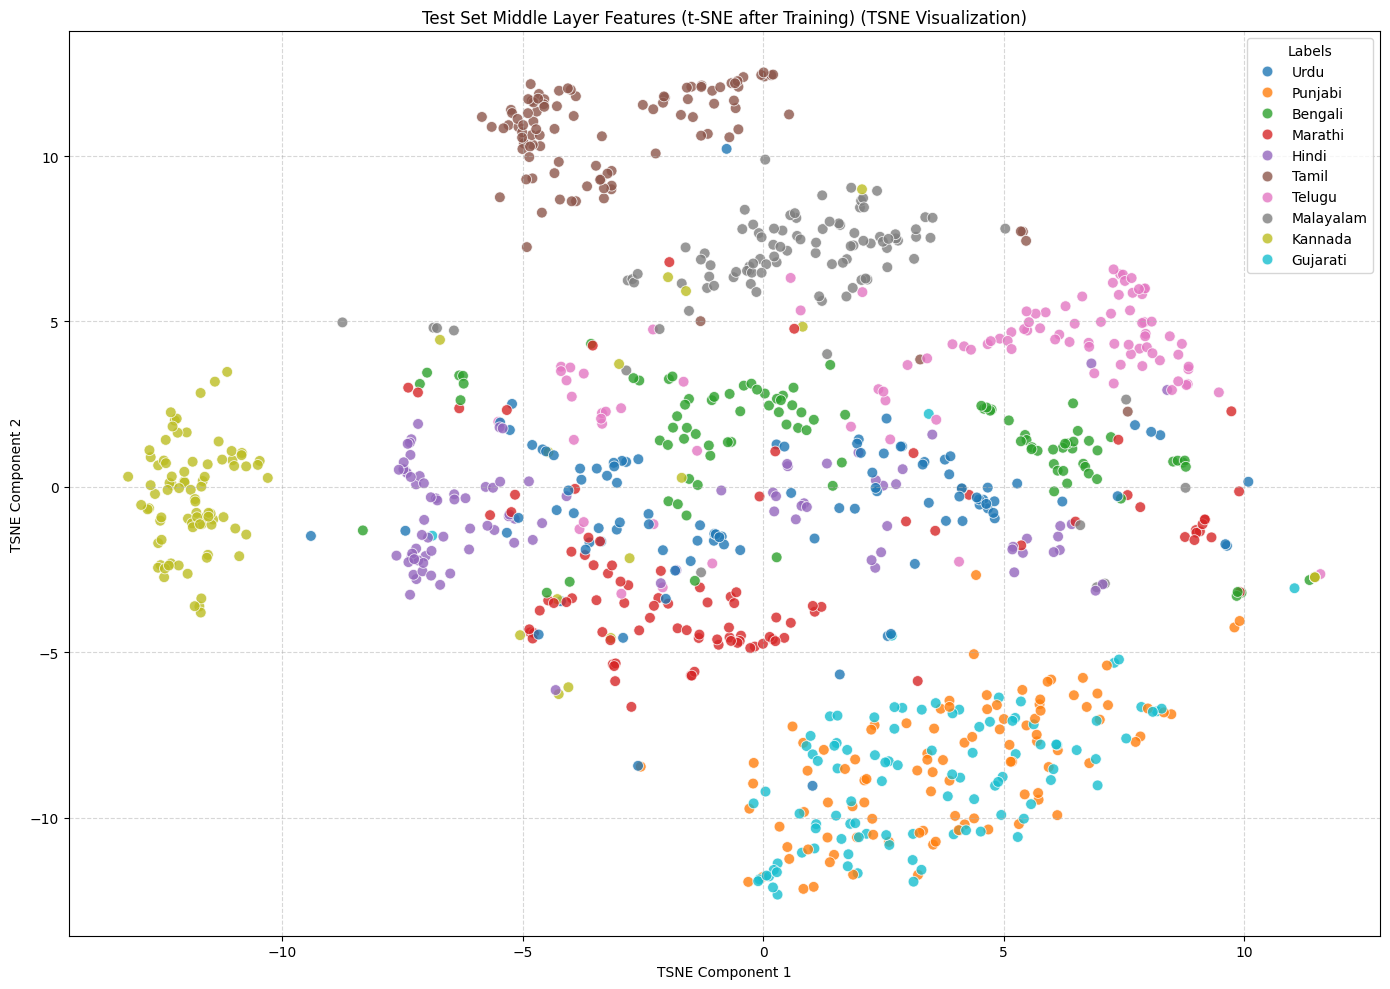


Script finished.


In [20]:

# 5. Final Visualization (After Training)
print("\n--- Trained Model Feature Visualization ---")
final_model_path = model_save_path if os.path.exists(model_save_path) else 'last_model_opl.pth'

if os.path.exists(final_model_path):
    print(f"Loading model from {final_model_path} for final visualization.")
    # Load state dict properly
    try:
            model.load_state_dict(torch.load(final_model_path, map_location=DEVICE))
    except Exception as e:
            print(f"Error loading model state_dict: {e}")
            print("Skipping final visualization.")

    if len(test_dataset) > 0:
        # Extract features from the middle layer (output of fc1)
        middle_features, middle_labels = get_embeddings_and_labels(
            test_loader_viz, model, DEVICE, extract_layer='middle'
        )

        if middle_features.size > 0 and middle_labels.size > 0:
            plot_embeddings(middle_features, middle_labels,
                            'Test Set Middle Layer Features (t-SNE after Training)',
                            method='tsne',
                            reverse_label_map=reverse_label_map)
        else:
                print("Could not extract features/labels from trained model. Skipping final plot.")
    else:
        print("Test dataset is empty. Skipping final visualization.")
else:
    print(f"No saved model found ({final_model_path}). Skipping final visualization.")

print("\nScript finished.")

In [ ]:
model_save_path = "/home/teaching/50_epoch_79_model_opl.pth"

# 5. Final Visualization (After Training)
print("\n--- Trained Model Feature Visualization ---")
final_model_path = model_save_path if os.path.exists(model_save_path) else 'model_trainedto25_eopchs.pth'

if os.path.exists(final_model_path):
    print(f"Loading model from {final_model_path} for final visualization.")
    # Load state dict properly
    try:
            model.load_state_dict(torch.load(final_model_path, map_location=DEVICE))
    except Exception as e:
            print(f"Error loading model state_dict: {e}")
            print("Skipping final visualization.")

    if len(test_dataset) > 0:
        # Extract features from the middle layer (output of fc1)
        middle_features, middle_labels = get_embeddings_and_labels(
            test_loader_viz, model, DEVICE, extract_layer='middle'
        )

        if middle_features.size > 0 and middle_labels.size > 0:
            # Example call focusing on the main cluster seen in your image
                plot_embeddings(
                    middle_features, middle_labels,
                    title="Test Set Middle Layer Features (Zoomed)",
                    method='pca', # Assuming the image was PCA
                    reverse_label_map=reverse_label_map, # Add your map here
                    xlim=(-72, 100),  # Adjust these based on visual inspection
                    ylim=(-100, 55)   # Adjust these based on visual inspection
                )
        else:
                print("Could not extract features/labels from trained model. Skipping final plot.")
    else:
        print("Test dataset is empty. Skipping final visualization.")
else:
    print(f"No saved model found ({final_model_path}). Skipping final visualization.")

print("\nScript finished.")


--- Model Training ---

--- Trained Model Feature Visualization ---
Loading model from /home/teaching/50_epoch_79_model_opl.pth for final visualization.
Error loading model state_dict: name 'model' is not defined
Skipping final visualization.


NameError: name 'model' is not defined

In [12]:

# 5. Final Visualization (After Training)
print("\n--- Trained Model Feature Visualization ---")
final_model_path = model_save_path if os.path.exists(model_save_path) else 'model_trainedto25_eopchs.pth'



--- Trained Model Feature Visualization ---


NameError: name 'model_save_path' is not defined

## 8. Confusion Matrix


--- Evaluating on Test Set ---

--- Model Training ---

--- Trained Model Feature Visualization ---
Loading model from /home/teaching/50_epoch_79_model_opl.pth for final visualization.


Testing: 100%|██████████| 32/32 [00:01<00:00, 31.54it/s]



Test Accuracy: 77.10%


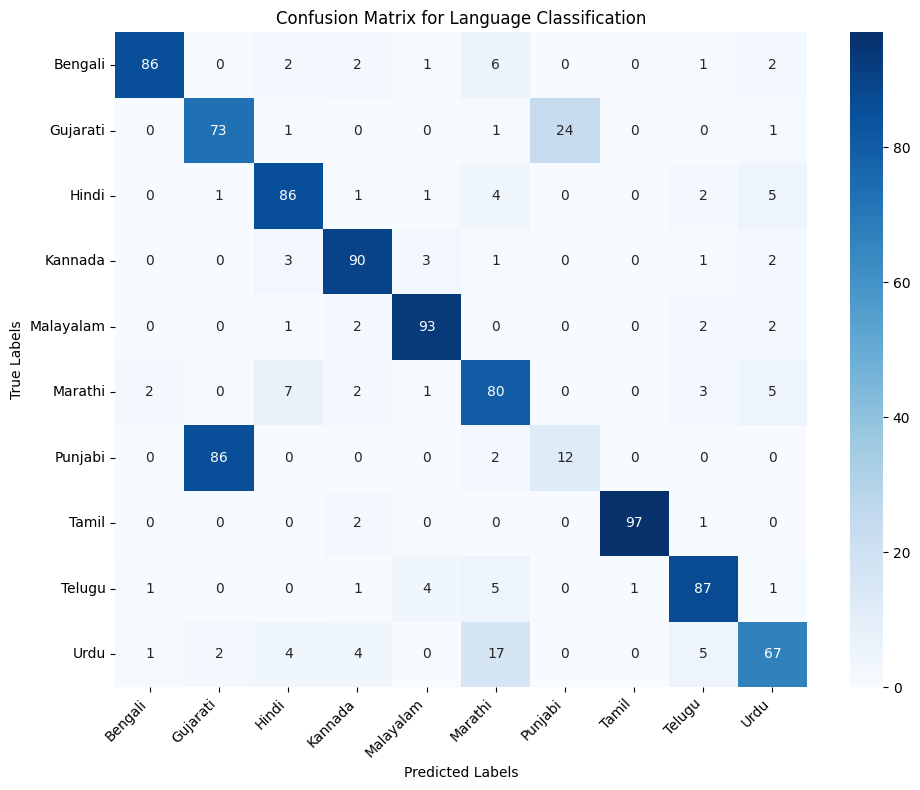

: 

In [ ]:
# Add these imports at the top of your script if they aren't already there
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # If you want progress bars

# --- Confusion Matrix Calculation ---
print("\n--- Evaluating on Test Set ---")
print("\n--- Model Training ---")

model = LanguageClassifier(input_dim=FLAT_INPUT_DIM,
                        middle_dim=MIDDLE_LAYER_DIM,
                        num_classes=NUM_CLASSES).to(DEVICE)
model_save_path = "../Weights/50_epoch_79_model_opl.pth"

# 5. Final Visualization (After Training)
print("\n--- Trained Model Feature Visualization ---")
final_model_path = model_save_path if os.path.exists(model_save_path) else 'model_trainedto25_eopchs.pth'

if os.path.exists(final_model_path):
    print(f"Loading model from {final_model_path} for final visualization.")
    # Load state dict properly
    try:
            model.load_state_dict(torch.load(final_model_path, map_location=DEVICE))
    except Exception as e:
            print(f"Error loading model state_dict: {e}")
            print("Skipping final visualization.")
# Ensure the model is in evaluation mode and on the correct device
model.eval()
model.to(DEVICE)

all_true_labels = []
all_pred_labels = []

# Use the test loader that yields true labels (e.g., test_loader_viz)
# Make sure test_loader_viz yields (inputs, labels)
if len(test_loader_viz) > 0: # Check if test set exists
    with torch.no_grad(): # Disable gradient calculation for inference
        for inputs, labels in tqdm(test_loader_viz, desc="Testing"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE) # Keep labels on device for potential comparison

            # Get model predictions
            # Your model returns (features, logits)
            _, logits = model(inputs)

            # Get the predicted class index
            predictions = torch.argmax(logits, dim=1)

            # Append batch results (move to CPU and convert to numpy/list)
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(predictions.cpu().numpy())

    if not all_true_labels:
         print("Warning: No true labels collected. Cannot calculate accuracy/confusion matrix.")
    else:
        # Calculate Accuracy
        accuracy = accuracy_score(all_true_labels, all_pred_labels)
        print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

        # Calculate Confusion Matrix
        cm = confusion_matrix(all_true_labels, all_pred_labels)

        # --- Plot Confusion Matrix ---
        plt.figure(figsize=(10, 8))
        # Use LANGUAGE_FOLDERS for labels if available and matches the label_map order
        # Otherwise, generate generic labels like ['Class 0', 'Class 1', ...]
        try:
            # Assuming label_map maps language name to index 0..N-1
            # and LANGUAGE_FOLDERS is ordered corresponding to indices 0..N-1
            tick_labels = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']
            if len(tick_labels) != NUM_CLASSES:
                 print("Warning: Mismatch between LANGUAGE_FOLDERS and NUM_CLASSES. Using generic labels.")
                 tick_labels = [f'Class {i}' for i in range(NUM_CLASSES)]
        except NameError:
            print("Warning: LANGUAGE_FOLDERS not found. Using generic labels.")
            tick_labels = [f'Class {i}' for i in range(NUM_CLASSES)]


        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=tick_labels, yticklabels=tick_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix for Language Classification')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        # You might want to save the plot instead of just showing it
        # plt.savefig("confusion_matrix.png")
        plt.show()

else:
    print("Test dataset is empty. Skipping evaluation.")

# --- End of Confusion Matrix Calculation ---